In [1]:
import subprocess
import os

import netCDF4
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import copy
import xarray as xr
from datetime import datetime, timedelta 
#from ocean_c_lab_tools import *
from celluloid import Camera 
import PyCO2SYS as csys
import seawater as sw
import xesmf as xe

/tmp/ipykernel_849231/3718686869.py:15: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
r2=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/Vedur_data/is750dev_20240819-29 2/netcdf_files/ig-is_202408*_rhum.nc')
ssr=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/Vedur_data/ig-is_202406-8/netcdf_files/ig-is_202408*_swavr.nc')
str=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/Vedur_data/ig-is_202406-8/netcdf_files/ig-is_202408*_lwavr.nc')
t2m=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/Vedur_data/is750dev_20240819-29 2/netcdf_files/ig-is_202408*_t2m.nc')
tp=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/Vedur_data/is750dev_20240819-29 2/netcdf_files/ig-is_202408*_tp.nc')
u10=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/Vedur_data/is750dev_20240819-29 2/netcdf_files/ig-is_202408*_u10.nc')
v10=xr.open_mfdataset('/global/cfs/cdirs/m4632/uheede/Vedur_data/is750dev_20240819-29 2/netcdf_files/ig-is_202408*_v10.nc')




/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: overflow encountered in exp
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in multiply
  return self.func(*new_argspec)


In [7]:
ssr.valid_time[0]

<xarray.DataArray 'valid_time' ()> Size: 8B
array('2024-08-01T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time               datetime64[ns] 8B 2024-08-01
    step               timedelta64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
    heightAboveGround  float64 8B 0.0
    valid_time         datetime64[ns] 8B 2024-08-01T01:00:00
Attributes:
    standard_name:  time
    long_name:      time

In [3]:
ssr=ssr.sel(valid_time=slice(r2.valid_time[0],r2.valid_time[-1]))

In [4]:
str=str.sel(valid_time=slice(r2.valid_time[0],r2.valid_time[-1]))

In [5]:
valid_time_seconds = (r2['valid_time'].astype('datetime64[s]') - np.datetime64('1970-01-01T00:00:00Z')).astype(int)/1e9


/tmp/ipykernel_849231/259878961.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  valid_time_seconds = (r2['valid_time'].astype('datetime64[s]') - np.datetime64('1970-01-01T00:00:00Z')).astype(int)/1e9
/tmp/ipykernel_849231/259878961.py:1: UserWarning: no explicit representation of timezones available for np.datetime64
  valid_time_seconds = (r2['valid_time'].astype('datetime64[s]') - np.datetime64('1970-01-01T00:00:00Z')).astype(int)/1e9


In [6]:
r2['time']=valid_time_seconds
ssr['time']=valid_time_seconds
str['time']=valid_time_seconds
t2m['time']=valid_time_seconds
tp['time']=valid_time_seconds
u10['time']=valid_time_seconds
v10['time']=valid_time_seconds

In [7]:
lon_min=np.min(r2.longitude.load())
lon_max=np.max(r2.longitude.load())

lon_step=((lon_max-lon_min)/len(r2.x))

lat_min=np.min(r2.latitude.load())
lat_max=np.max(r2.latitude.load())
lat_step=((lat_max-lat_min)/len(r2.y))

In [8]:
ds_out = xr.Dataset(
    {
        "lon": (["lon"], np.arange(lon_min, lon_max, lon_step), {"units": "degrees_north"}),
        "lat": (["lat"], np.arange(lat_min, lat_max, lat_step), {"units": "degrees_east"}),
    }
)

In [ ]:
ds_out

In [9]:
regridder = xe.Regridder(r2, ds_out, "bilinear")
regridder2 = xe.Regridder(ssr, ds_out, "bilinear")
r2_regrid=regridder(r2['rhum'])

ssr_regrid=regridder2(ssr['swavr'])
str_regrid=regridder2(str['lwavr'])
t2m_regrid=regridder(t2m['t2m'])
tp_regrid=regridder(tp['tp']*0.001) # convert from kg/m2 to m
u10_regrid=regridder(u10['u10'])
v10_regrid=regridder(v10['v10'])

In [ ]:
r2_regrid

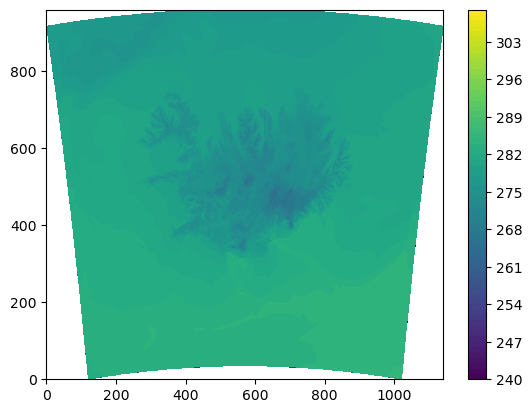

In [15]:
levels=np.arange(240,310,1)
cf=plt.contourf(t2m_regrid.isel(valid_time=0),levels)
plt.colorbar(cf)

In [10]:
p=101000
e=610.94*np.exp(17.625*(t2m_regrid-273.15)/((t2m_regrid-273.15)+243.04))*r2_regrid
q = (0.622 * e) / (p - (1 - 0.622) * e)


/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: overflow encountered in exp
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in multiply
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: overflow encountered in exp
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: overflow encountered in exp
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in multiply
  return self.func(*new_argspec)
/global/homes/u/uheede/.conda/envs/xesmf_env/lib/python3.12/site-packages/dask/_task_spec.py:651: Runtime

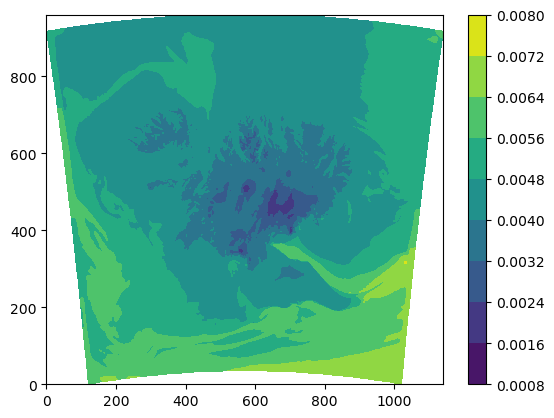

In [17]:
cf=plt.contourf(q.isel(valid_time=0))
plt.colorbar(cf)

In [11]:
sh2_regrid = q

In [12]:
r2_regrid.attrs['long name'] = '2 metre relative humidity'
r2_regrid=r2_regrid.reset_coords(names="heightAboveGround",drop=True)
#r2_regrid=r2_regrid.rename({"rhum":'r2'})

sh2_regrid.attrs['long name'] = '2 metre specific humidity'
sh2_regrid=sh2_regrid.reset_coords(names="heightAboveGround",drop=True)

ssr_regrid.attrs['long name'] = 'Surface net short-wave (solar) radiation'
ssr_regrid=ssr_regrid.reset_coords(names="heightAboveGround",drop=True)
#ssr_regrid=ssr_regrid.rename({"swavr":'ssr'})

str_regrid.attrs['long name'] = 'Surface long-wave (thermal) radiation downwards'
str_regrid=str_regrid.reset_coords(names="heightAboveGround",drop=True)
#str_regrid=str_regrid.rename({"lwavr":'str'})

u10_regrid.attrs['long name'] = '10 metre U wind component'
u10_regrid=u10_regrid.reset_coords(names="heightAboveGround",drop=True)

v10_regrid.attrs['long name'] = '10 metre V wind component'
v10_regrid=v10_regrid.reset_coords(names="heightAboveGround",drop=True)

t2m_regrid.attrs['long name'] = '2 metre temperature'
t2m_regrid=t2m_regrid.reset_coords(names="heightAboveGround",drop=True)

tp_regrid.attrs['long name'] = 'total precipitation'
tp_regrid=tp_regrid.reset_coords(names="heightAboveGround",drop=True)


In [17]:
ssr_regrid=ssr_regrid.reset_coords(names="step",drop=True)
str_regrid=str_regrid.reset_coords(names="step",drop=True)


In [13]:
print(u10_regrid.time)
print(v10_regrid.time)
print(t2m_regrid.time)
print(tp_regrid.time)
print(ssr_regrid.time)
print(str_regrid.time)
print(sh2_regrid.time)

<xarray.DataArray 'time' (valid_time: 258)> Size: 2kB
array([1.7240292e+09, 1.7240328e+09, 1.7240364e+09, 1.7240400e+09,
       1.7240436e+09, 1.7240472e+09, 1.7240508e+09, 1.7240544e+09,
       1.7240580e+09, 1.7240616e+09, 1.7240652e+09, 1.7240688e+09,
       1.7240940e+09, 1.7240976e+09, 1.7241012e+09, 1.7241048e+09,
       1.7241084e+09, 1.7241120e+09, 1.7241156e+09, 1.7241192e+09,
       1.7241228e+09, 1.7241264e+09, 1.7241300e+09, 1.7241336e+09,
       1.7241372e+09, 1.7241408e+09, 1.7241444e+09, 1.7241480e+09,
       1.7241516e+09, 1.7241552e+09, 1.7241588e+09, 1.7241624e+09,
       1.7241660e+09, 1.7241696e+09, 1.7241732e+09, 1.7241768e+09,
       1.7241804e+09, 1.7241840e+09, 1.7241876e+09, 1.7241912e+09,
       1.7241948e+09, 1.7241984e+09, 1.7242020e+09, 1.7242056e+09,
       1.7242092e+09, 1.7242128e+09, 1.7242164e+09, 1.7242200e+09,
       1.7242236e+09, 1.7242272e+09, 1.7242308e+09, 1.7242344e+09,
       1.7242380e+09, 1.7242416e+09, 1.7242452e+09, 1.7242488e+09,
       1

In [18]:
vedur_2024 = xr.Dataset({
    'u10': u10_regrid.load().squeeze(),
    'v10': v10_regrid.load().squeeze(),
    't2m': t2m_regrid.load().squeeze(),
    'strd': str_regrid.load().squeeze(),
    'ssr': ssr_regrid.load().squeeze(),
    'sh2': sh2_regrid.load().squeeze(),
    'tp': tp_regrid.load().squeeze(),
    'longitude': u10_regrid.load().lon,
    'latitude': u10_regrid.load().lat})

In [16]:
str_regrid

<xarray.DataArray (valid_time: 264, lat: 961, lon: 1141)> Size: 1GB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2024-08-19T01:00:00 ... 2024-...
    time        (valid_time) float64 2kB 1.724e+09 1.724e+09 ... 1.725e+09
    step        (valid_time) timedelta64[ns] 2kB 01:00:00 02:00:00 ... 03:00:00
  * lon         (lon) float64 9kB 330.9 330.9 330.9 330.9 ... 351.1 351.1 351.1
  * lat         (lat) float64 8kB 61.22 61.23 61.24 61.24 ... 67.91 67.92 67.93
Attributes:
    regrid_method:  bilinear
    long name:      Surface long-wave (thermal) radiation downwards

In [ ]:
vedur_2024 = xr.Dataset({
    'strd': str_regrid.load().squeeze(),
    'ssr': ssr_regrid.load().squeeze(),

In [ ]:
#vedur_2024 = vedur_2024.set_index(time='valid_time')

In [19]:
vedur_2024.to_netcdf('/global/cfs/cdirs/m4632/uheede/Vedur_data/is750dev_20240819-29 2/netcdf_files/vedur_750m_202408.nc')




In [ ]:
vedur_2024

In [ ]:
720/24